## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
from datasets import load_from_disk

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="paper", style="ticks")

## Load cached dataset

In [4]:
dataset_name = "ami"

savepath = f"notebooks/data/whisper_hallucinations_cached_ds/{dataset_name}"
ds = load_from_disk(savepath)

ds.features

{'text': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'teacher_text': Value(dtype='string', id=None),
 'teacher_labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'audio_length': Value(dtype='float64', id=None),
 'n_tokens_labels': Value(dtype='int64', id=None),
 'n_tokens_teacher': Value(dtype='int64', id=None),
 'n_overlaps': Value(dtype='int64', id=None),
 'is_fast_utterance': Value(dtype='bool', id=None),
 'diff_n_tokens': Value(dtype='int64', id=None),
 'max_token_repetitions_labels': Value(dtype='int64', id=None),
 'max_token_repetitions_teacher': Value(dtype='int64', id=None)}

## Convert to DataFrame

In [5]:
df = pd.DataFrame({col: ds[col] for col in ds.features.keys() if col != "audio"})

df.head()

,text,labels,teacher_text,teacher_labels,audio_length,n_tokens_labels,n_tokens_teacher,n_overlaps,is_fast_utterance,diff_n_tokens,max_token_repetitions_labels,max_token_repetitions_teacher
0,yeah,"[50258, 50363, 19650, 50257]",no.,"[50258, 50363, 572, 13, 50257]",1.37,4,5,0,False,1,1,1
1,mm-hmm,"[50258, 50363, 2174, 12, 10250, 50257]",mm-hmm.,"[50258, 50363, 11169, 12, 10250, 13, 50257]",0.37,6,7,0,False,1,1,1
2,yeah we're gonna meet up,"[50258, 50363, 19650, 321, 434, 799, 1677, 493...","yeah, we're going to meet up.","[50258, 50363, 1338, 11, 321, 434, 516, 220, 1...",1.18,9,13,0,False,4,1,1
3,i mean we're not even there yet,"[50258, 50363, 72, 914, 321, 434, 406, 754, 22...","i mean, we're not even there yet.","[50258, 50363, 741, 914, 11, 321, 434, 406, 75...",1.36,12,14,0,False,2,1,1
4,yeah,"[50258, 50363, 19650, 50257]",yeah.,"[50258, 50363, 1338, 13, 50257]",0.29,4,5,0,False,1,1,1


## First analysis

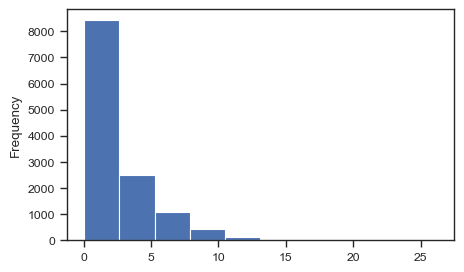

In [6]:
plt.figure(figsize=(5, 3))
df["audio_length"].plot.hist();

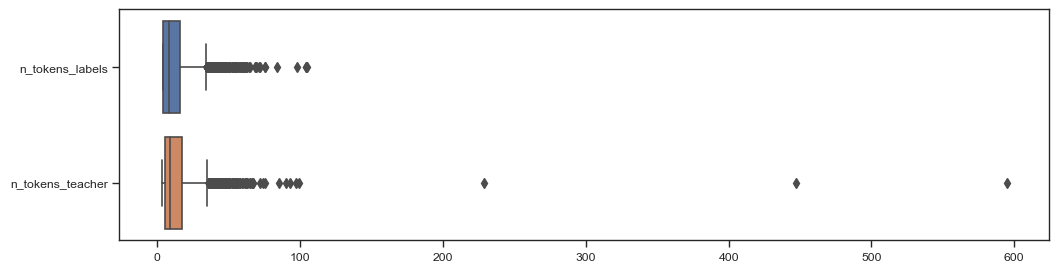

In [7]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=df[["n_tokens_labels", "n_tokens_teacher"]], orient="h");

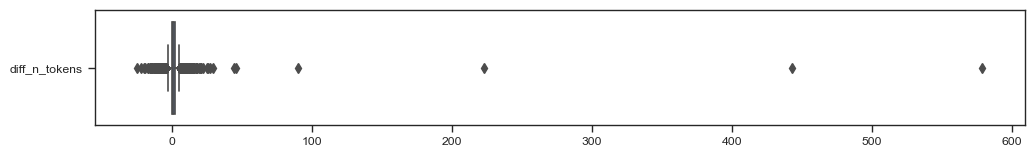

In [8]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h");

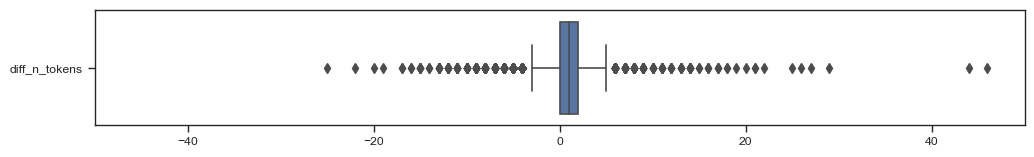

In [9]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h")
plt.xlim(-50, 50);

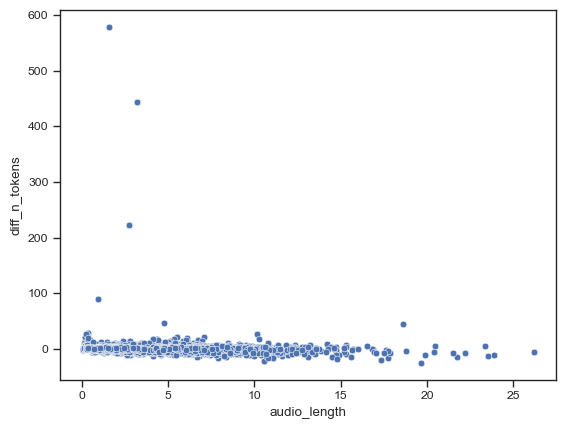

In [10]:
sns.scatterplot(data=df, x="audio_length", y="diff_n_tokens");

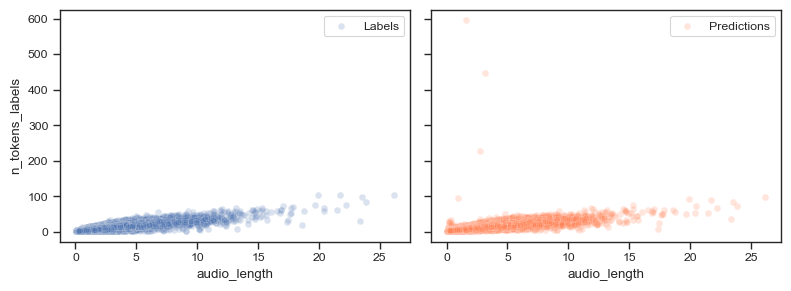

In [11]:
fig, axis = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
sns.scatterplot(data=df, x="audio_length", y="n_tokens_labels", label="Labels", alpha=0.2, ax=axis[0])
sns.scatterplot(data=df, x="audio_length", y="n_tokens_teacher", label="Predictions", c="coral", alpha=0.2, ax=axis[1])
fig.tight_layout()

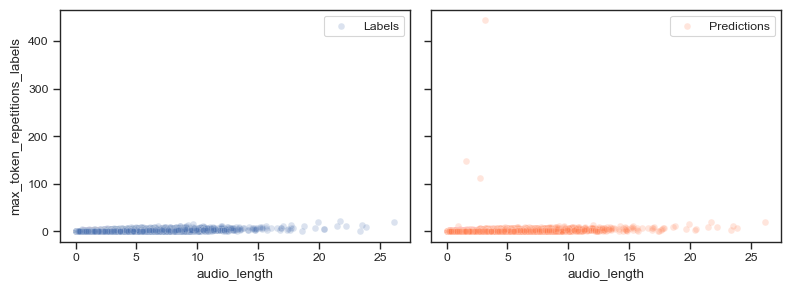

In [12]:
fig, axis = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
sns.scatterplot(data=df, x="audio_length", y="max_token_repetitions_labels", label="Labels", alpha=0.2, ax=axis[0])
sns.scatterplot(data=df, x="audio_length", y="max_token_repetitions_teacher", label="Predictions", c="coral", alpha=0.2, ax=axis[1])
fig.tight_layout()

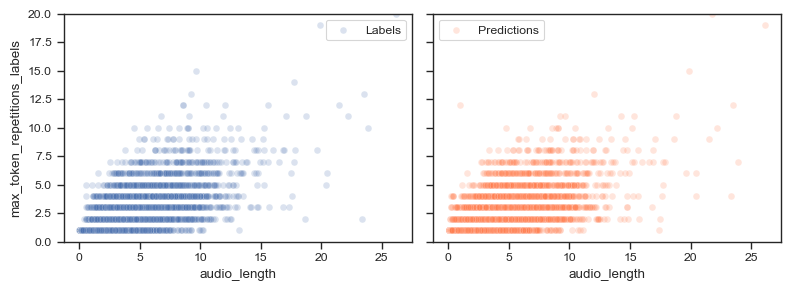

In [13]:
fig, axis = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
sns.scatterplot(data=df, x="audio_length", y="max_token_repetitions_labels", label="Labels", alpha=0.2, ax=axis[0])
sns.scatterplot(data=df, x="audio_length", y="max_token_repetitions_teacher", label="Predictions", c="coral", alpha=0.2, ax=axis[1])
for ax in axis.flatten():
    ax.set_ylim(0, 20)
fig.tight_layout()

In [14]:
df["diff_max_token_repetitions"] = df["max_token_repetitions_teacher"] - df["max_token_repetitions_labels"]

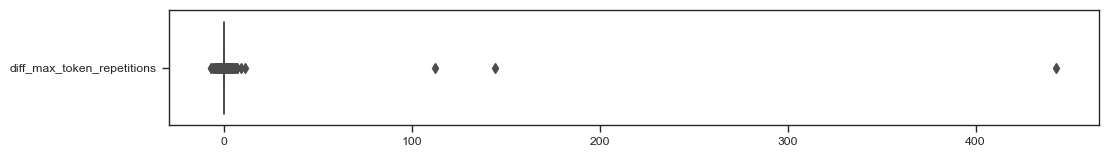

In [15]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_max_token_repetitions"]], orient="h");

(-10.0, 10.0)

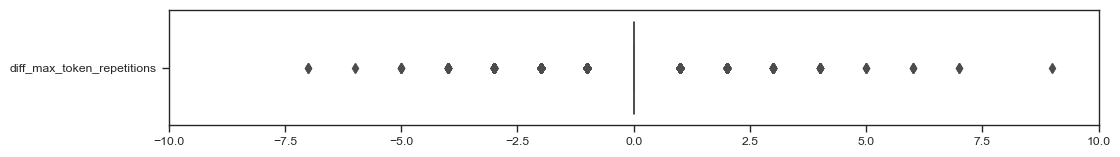

In [16]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_max_token_repetitions"]], orient="h")
plt.xlim(-10, 10)

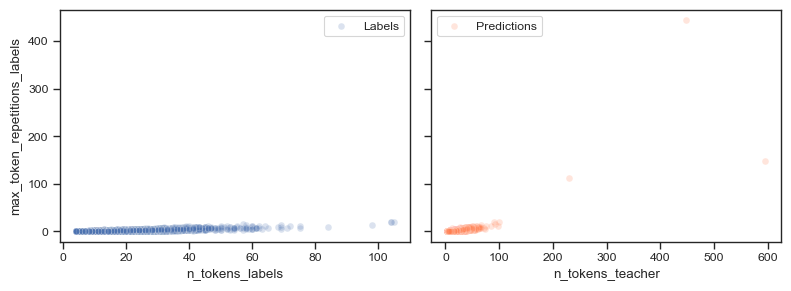

In [17]:
fig, axis = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
sns.scatterplot(data=df, x="n_tokens_labels", y="max_token_repetitions_labels", label="Labels", alpha=0.2, ax=axis[0])
sns.scatterplot(data=df, x="n_tokens_teacher", y="max_token_repetitions_teacher", label="Predictions", c="coral", alpha=0.2, ax=axis[1])
fig.tight_layout()

## Criteria for filtering

### `high_diff_n_tokens`

In [18]:
DELTA_N_TOKENS = 20
df["high_diff_n_tokens"] = (df["diff_n_tokens"] > DELTA_N_TOKENS)

In [19]:
df["high_diff_n_tokens"].value_counts()

False    12630
True        13
Name: high_diff_n_tokens, dtype: int64

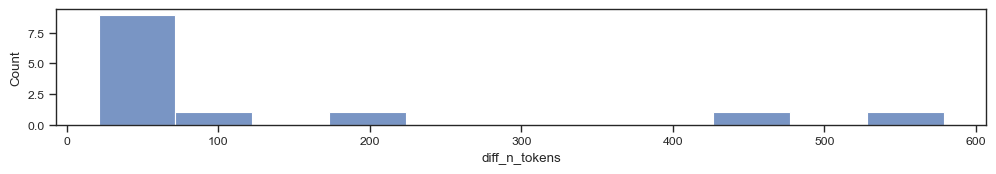

In [20]:
plt.figure(figsize=(12, 1.5))
sns.histplot(data=df[df["high_diff_n_tokens"]], x="diff_n_tokens");

### Difference in number of tokens

In [21]:
df_candidates = df[df["diff_n_tokens"]>=10]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 38
Reference:  but well whatever it was last week then
Prediction:   but... i mean, this week's only two days on. well, whatever it was last week then.

Idx = 168
Reference:  yeah
Prediction:   ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha

Most of the repeated-type hallucinations happen for short audio lengths (< 5s).

### Difference in max number of repeated tokens

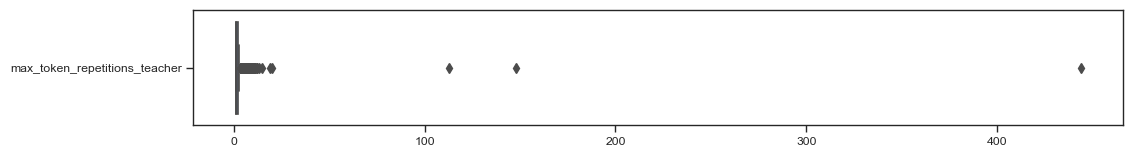

In [22]:
plt.figure(figsize=(12, 1.5));
sns.boxplot(data=df[["max_token_repetitions_teacher"]], orient="h");

In [23]:
df_candidates = df[df["max_token_repetitions_teacher"]>=7]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 168
Reference:  yeah
Prediction:   ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha

### Word per second (WPS)

In [24]:
df["wps"] = df["teacher_text"].str.split(" ").str.len() / df["audio_length"]

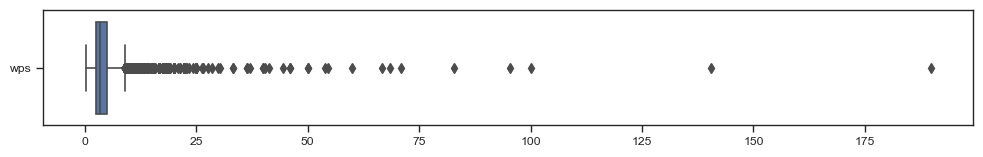

In [25]:
plt.figure(figsize=(12, 1.5));
sns.boxplot(data=df[["wps"]], orient="h");

In [26]:
df_candidates = df[(df["wps"] > 10) & (df["audio_length"] > 1)]
print(len(df_candidates))

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()
    if idx > 10:
        break

3
Idx = 168
Reference:  yeah
Prediction:   ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha 

### `diff_max_token_repetitions`

In [27]:
df_candidates = df[df["diff_max_token_repetitions"]>=4]
print(len(df_candidates))

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()
    if idx > 10:
        break

24
Idx = 168
Reference:  yeah
Prediction:   ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha

### `n_overlaps`

In [28]:
df["n_overlaps"].value_counts()

0    12631
1       12
Name: n_overlaps, dtype: int64

In [29]:
ds_candidate = ds.filter(lambda x: x["n_overlaps"] >= 1)

for idx, row in enumerate(ds_candidate):
    print("Index: ", idx)
    print("Reference: ", row["text"])
    print("Pred: ", row["teacher_text"])
    print()

Loading cached processed dataset at /Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models/notebooks/data/whisper_hallucinations_cached_ds/ami/cache-3c5b4b122aabb286.arrow


Index:  0
Reference:  um um well it's in the code
Pred:   um, well, it's in the code.

Index:  1
Reference:  what um i thought what we sorta discussed last week was to have it sort um the same window
Pred:   what, i think what we sort of discussed last week was to have it on the same window.

Index:  2
Reference:  oh well basically not not unless you've got time for at the end
Pred:   well, basically not unless you've got time for it at the end.

Index:  3
Reference:  right so anyone else got anything to say
Pred:   right, so anyone else got anything to say?

Index:  4
Reference:  yeah just just just disregard it yeah
Pred:   yeah, just disregard it, yeah.

Index:  5
Reference:  indepen independent right did you say they're good at golf
Pred:   independent, right? did you say they're good at golf?

Index:  6
Reference:  well it was it was an at first firstly it was an attempt at a t. rex and then it sort of changed into a pelican but it can be a crocodile now actually
Pred:   well, fir

### `is_fast_utterance`

In [30]:
df["is_fast_utterance"].value_counts()

False    12625
True        18
Name: is_fast_utterance, dtype: int64

In [31]:
ds_candidate = ds.filter(lambda x: x["is_fast_utterance"])

for idx, row in enumerate(ds_candidate):
    print("Index: ", idx)
    print("Reference: ", row["text"])
    print("Pred: ", row["teacher_text"])
    print()

Loading cached processed dataset at /Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models/notebooks/data/whisper_hallucinations_cached_ds/ami/cache-b05aaa9eaf33b98a.arrow


Index:  0
Reference:  yeah
Pred:   ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha